# Training the Model

## 1. Imports

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tempfile
from sklearn import metrics
import time
from time import time
import torch
from tqdm import tqdm
import monai
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandRicianNoised,
    RandRotated,
    Resized,
    Rotate90d,
    ScaleIntensityd,
    DeleteItemsd
)


### 1.1 Set Environment Variables for GPU

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

### 1.2 Get Stored Dictionaries from CreateDataset

In [3]:
%store -r dictionary_train
%store -r dictionary_valid
%store -r dictionary_test

## 2. MONAI Dataloader

### 2.1 Data Transforms

In [4]:
#To turn 4D images to 3D (from Ashley's classifier)
class MakeSingleVolumed(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            num_volumes = data[key].shape[0]
            data["NumVolumes"] = num_volumes
            
            if num_volumes != 1:
                middle_volume = num_volumes // 2
                new_data = np.empty((1,128,128,64))
                new_data[0,:,:,:] = data[key][middle_volume,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
            else:
                new_data = np.empty((1,128,128,64))
                new_data[0,:,:,:] = data[key][0,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
                
        return data

#This uses the mask to scale the intensity of the image (not being used rn)
class ScaleImaged(MapTransform):
    def __call__(self, data):
            data[self.keys[0]] *= (0.4+data[self.keys[1]])

            return data


#### 2.1.1 Set Training and Validation Transforms

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["t1", "t1c", "t2", "flair"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["t1", "t1c", "t2", "flair"]),
        Orientationd(keys=["t1", "t1c", "t2", "flair"], axcodes="RAS"),        
        EnsureTyped(keys=["t1", "t1c", "t2", "flair"]),
        Resized(keys=["t1", "t1c", "t2", "flair"], spatial_size=(128,128,64)),
        MakeSingleVolumed(keys=["t1", "t1c", "t2", "flair"]),
        Rotate90d(keys=["t1", "t1c", "t2", "flair"]),
        ScaleIntensityd(keys=["t1", "t1c", "t2", "flair"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["t1", "t1c", "t2", "flair"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["t1", "t1c", "t2", "flair"]),
        Orientationd(keys=["t1", "t1c", "t2", "flair"], axcodes="RAS"),        
        EnsureTyped(keys=["t1", "t1c", "t2", "flair"]),
        Resized(keys=["t1", "t1c", "t2", "flair"], spatial_size=(128,128,64)),
        MakeSingleVolumed(keys=["t1", "t1c", "t2", "flair"]),
        Rotate90d(keys=["t1", "t1c", "t2", "flair"]),
        ScaleIntensityd(keys=["t1", "t1c", "t2", "flair"]),
    ]
)

#### 2.1.2 Test the Transforms


In [6]:
val_files = dictionary_train[:10]

check_ds = Dataset(data=val_files, transform=train_transforms)
check_DataLoader = DataLoader(check_ds, batch_size=1, shuffle=False)

It has been 18.99448251724243 seconds since the loop started


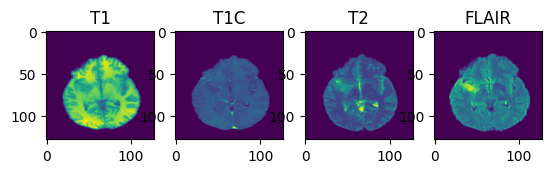

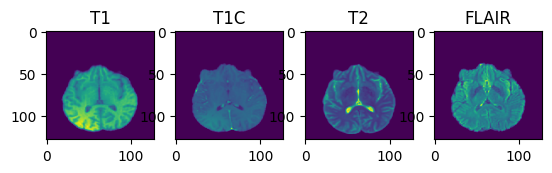

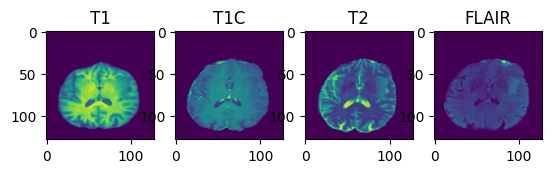

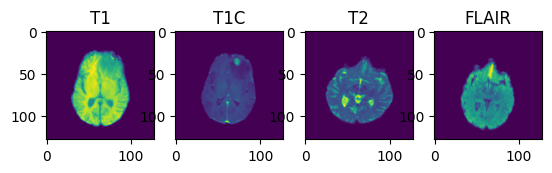

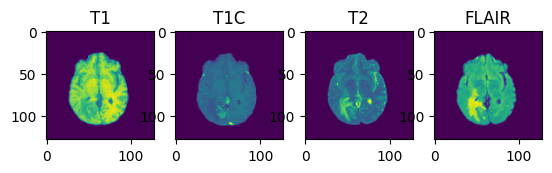

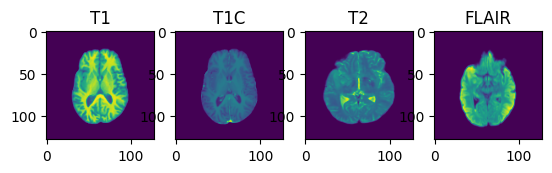

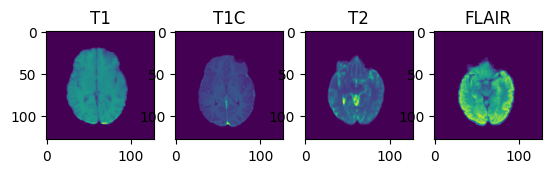

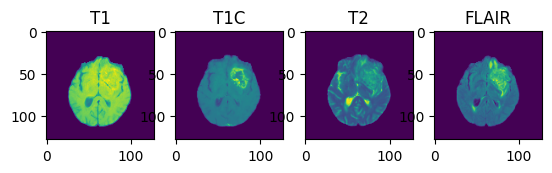

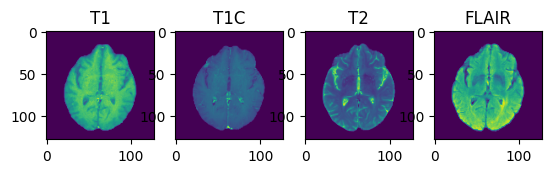

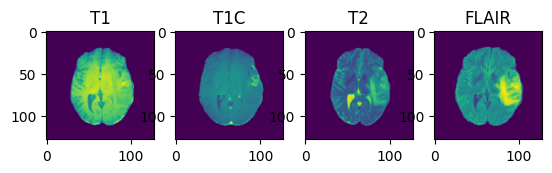

In [7]:
program_starts = time()
step = 1350
slice_index = 32
for item in check_DataLoader:
    image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index]
    title = item["MGMTp"]
    f, axarr = plt.subplots(1, 4)
    
    axarr[0].imshow(image_datas[0])
    axarr[0].set_title("T1")
    axarr[1].imshow(image_datas[1])
    axarr[1].set_title("T1C")
    axarr[2].imshow(image_datas[2])
    axarr[2].set_title("T2")
    axarr[3].imshow(image_datas[3])
    axarr[3].set_title("FLAIR")
    
    step += 1
now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

## 2.2 Create Train/Valid/Test DataLoaders

In [8]:
print(os.cpu_count())

train_ds = CacheDataset(data=dictionary_train, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=os.cpu_count())

valid_ds = CacheDataset(data=dictionary_valid, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=False, num_workers=os.cpu_count())

test_ds = CacheDataset(data=dictionary_test, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=os.cpu_count())

20


Loading dataset: 100%|██████████████████████████| 84/84 [00:55<00:00,  1.51it/s]


## 3. DenseNet Model (for now)

### 3.1 Model and Device Setup


In [9]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = monai.networks.nets.DenseNet121(
    spatial_dims=3,
    in_channels=4,
    out_channels=2,
)

# If multiple GPUs are available, run in parallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)
model.to(device)

loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), 4e-5)

cuda
Let's use 4 GPUs!


#### 3.1.1 Helper Function to Visualize Training Curves

In [10]:
def plot_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure("train", (12, 12))

    plt.subplot(2, 1, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(train_loss))]
    y = train_loss
    plt.xlabel("epoch")
    plt.plot(x, y)
    x = [i + 1 for i in range(len(val_loss))]
    y = val_loss
    plt.plot(x, y)
    plt.legend(('Training', 'Validation'))


    plt.subplot(2, 1, 2)
    plt.title("Accuracy")
    x = [(i + 1) for i in range(len(train_acc))]
    y = train_acc
    plt.xlabel("epoch")
    plt.plot(x, y)
    x = [(i + 1) for i in range(len(val_acc))]
    y = val_acc
    plt.plot(x, y)
    plt.legend(('Training', 'Validation'))
    
    plt.show()

### 3.2 Training

----------
epoch 1/20


Epoch : 100%|██████| 43/43 [00:31<00:00,  1.38it/s, Overall Training Loss=0.754]


saved new best metric model
current epoch: 1 current avg accuracy: 0.5000 best accuracy: 0.5000 at epoch 1
Num guessed positive: 
335
train accuracy: 0.5118 validation accuracy: 0.5000 train loss: 0.6992 validation loss 0.6939
----------
epoch 2/20


Epoch : 100%|██████| 43/43 [00:27<00:00,  1.59it/s, Overall Training Loss=0.751]


saved new best metric model
current epoch: 2 current avg accuracy: 0.5238 best accuracy: 0.5238 at epoch 2
Num guessed positive: 
489
train accuracy: 0.5324 validation accuracy: 0.5238 train loss: 0.6864 validation loss 0.7402
----------
epoch 3/20


Epoch : 100%|██████| 43/43 [00:27<00:00,  1.59it/s, Overall Training Loss=0.744]


current epoch: 3 current avg accuracy: 0.5119 best accuracy: 0.5238 at epoch 2
Num guessed positive: 
363
train accuracy: 0.6091 validation accuracy: 0.5119 train loss: 0.6641 validation loss 0.7644
----------
epoch 4/20


Epoch : 100%|██████| 43/43 [00:27<00:00,  1.57it/s, Overall Training Loss=0.641]


current epoch: 4 current avg accuracy: 0.4643 best accuracy: 0.5238 at epoch 2
Num guessed positive: 
359
train accuracy: 0.6239 validation accuracy: 0.4643 train loss: 0.6549 validation loss 0.7399
----------
epoch 5/20


Epoch : 100%|██████| 43/43 [00:27<00:00,  1.59it/s, Overall Training Loss=0.777]


current epoch: 5 current avg accuracy: 0.5119 best accuracy: 0.5238 at epoch 2
Num guessed positive: 
416
train accuracy: 0.6195 validation accuracy: 0.5119 train loss: 0.6515 validation loss 0.7186


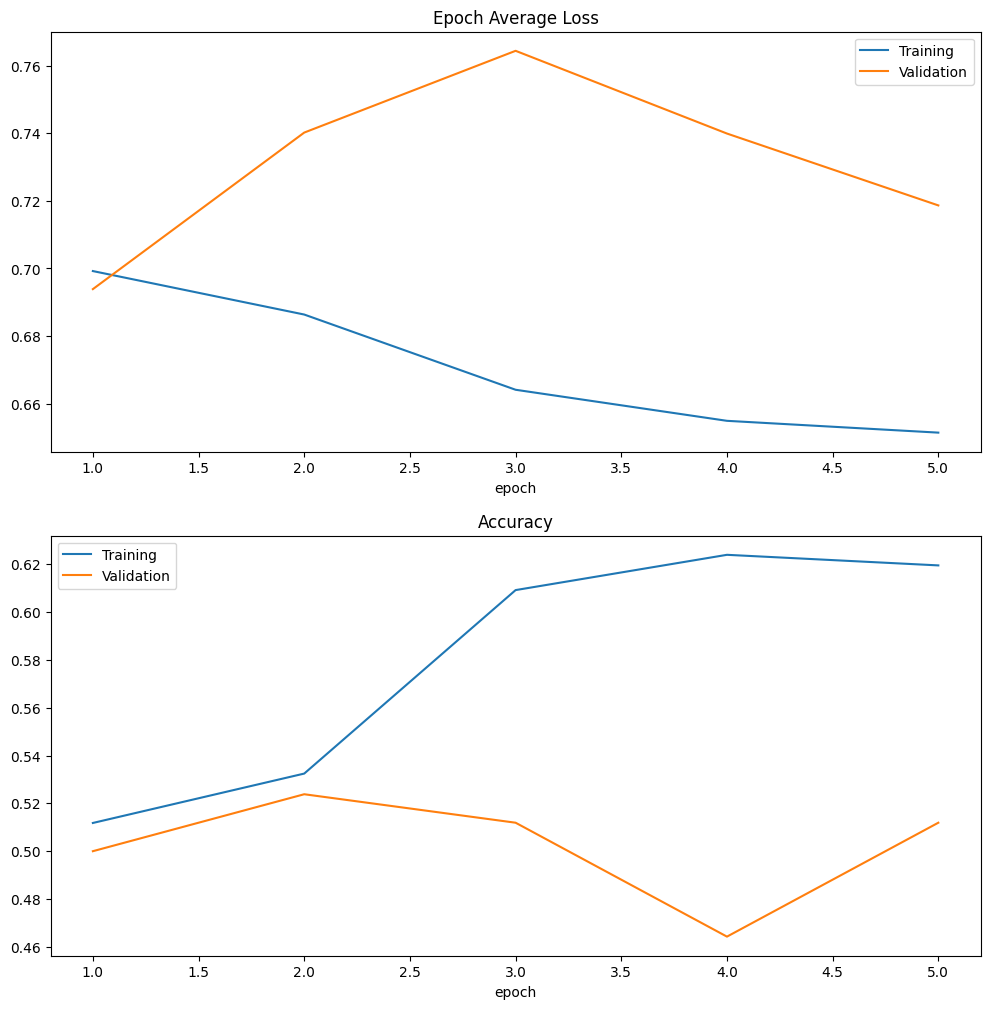

----------
epoch 6/20


Epoch : 100%|██████| 43/43 [00:26<00:00,  1.60it/s, Overall Training Loss=0.537]


saved new best metric model
current epoch: 6 current avg accuracy: 0.5476 best accuracy: 0.5476 at epoch 6
Num guessed positive: 
370
train accuracy: 0.6136 validation accuracy: 0.5476 train loss: 0.6486 validation loss 0.6952
----------
epoch 7/20


Epoch : 100%|██████| 43/43 [00:26<00:00,  1.61it/s, Overall Training Loss=0.519]


current epoch: 7 current avg accuracy: 0.5119 best accuracy: 0.5476 at epoch 6
Num guessed positive: 
393
train accuracy: 0.6829 validation accuracy: 0.5119 train loss: 0.6091 validation loss 1.0357
----------
epoch 8/20


Epoch : 100%|██████| 43/43 [00:26<00:00,  1.61it/s, Overall Training Loss=0.674]


current epoch: 8 current avg accuracy: 0.4524 best accuracy: 0.5476 at epoch 6
Num guessed positive: 
375
train accuracy: 0.6593 validation accuracy: 0.4524 train loss: 0.6309 validation loss 0.7835
----------
epoch 9/20


Epoch : 100%|██████| 43/43 [00:27<00:00,  1.58it/s, Overall Training Loss=0.799]


current epoch: 9 current avg accuracy: 0.5119 best accuracy: 0.5476 at epoch 6
Num guessed positive: 
372
train accuracy: 0.6873 validation accuracy: 0.5119 train loss: 0.6052 validation loss 0.7814
----------
epoch 10/20


Epoch : 100%|██████| 43/43 [00:27<00:00,  1.59it/s, Overall Training Loss=0.618]


current epoch: 10 current avg accuracy: 0.4524 best accuracy: 0.5476 at epoch 6
Num guessed positive: 
383
train accuracy: 0.7124 validation accuracy: 0.4524 train loss: 0.5710 validation loss 0.9535


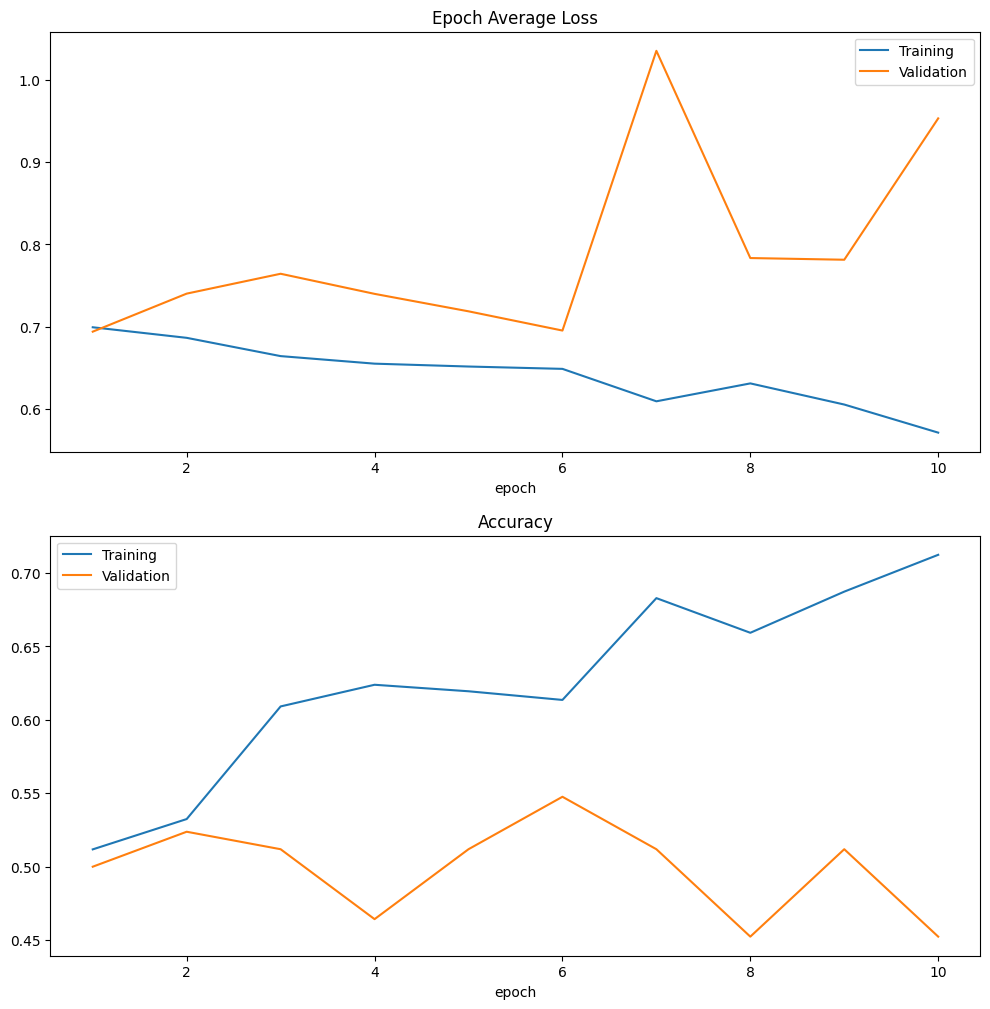

----------
epoch 11/20


Epoch : 100%|██████| 43/43 [00:27<00:00,  1.58it/s, Overall Training Loss=0.577]


saved new best metric model
current epoch: 11 current avg accuracy: 0.5952 best accuracy: 0.5952 at epoch 11
Num guessed positive: 
378
train accuracy: 0.7640 validation accuracy: 0.5952 train loss: 0.5193 validation loss 0.7721
----------
epoch 12/20


Epoch : 100%|██████| 43/43 [00:27<00:00,  1.58it/s, Overall Training Loss=0.511]


current epoch: 12 current avg accuracy: 0.5238 best accuracy: 0.5952 at epoch 11
Num guessed positive: 
342
train accuracy: 0.7699 validation accuracy: 0.5238 train loss: 0.4808 validation loss 1.1381
----------
epoch 13/20


Epoch : 100%|██████| 43/43 [00:26<00:00,  1.60it/s, Overall Training Loss=0.348]


current epoch: 13 current avg accuracy: 0.5952 best accuracy: 0.5952 at epoch 11
Num guessed positive: 
360
train accuracy: 0.7788 validation accuracy: 0.5952 train loss: 0.4880 validation loss 0.7730
----------
epoch 14/20


Epoch : 100%|██████| 43/43 [00:27<00:00,  1.58it/s, Overall Training Loss=0.597]


current epoch: 14 current avg accuracy: 0.5238 best accuracy: 0.5952 at epoch 11
Num guessed positive: 
373
train accuracy: 0.7566 validation accuracy: 0.5238 train loss: 0.5038 validation loss 0.9431
----------
epoch 15/20


Epoch : 100%|██████| 43/43 [00:27<00:00,  1.58it/s, Overall Training Loss=0.147]


saved new best metric model
current epoch: 15 current avg accuracy: 0.6071 best accuracy: 0.6071 at epoch 15
Num guessed positive: 
376
train accuracy: 0.8230 validation accuracy: 0.6071 train loss: 0.4028 validation loss 0.9284


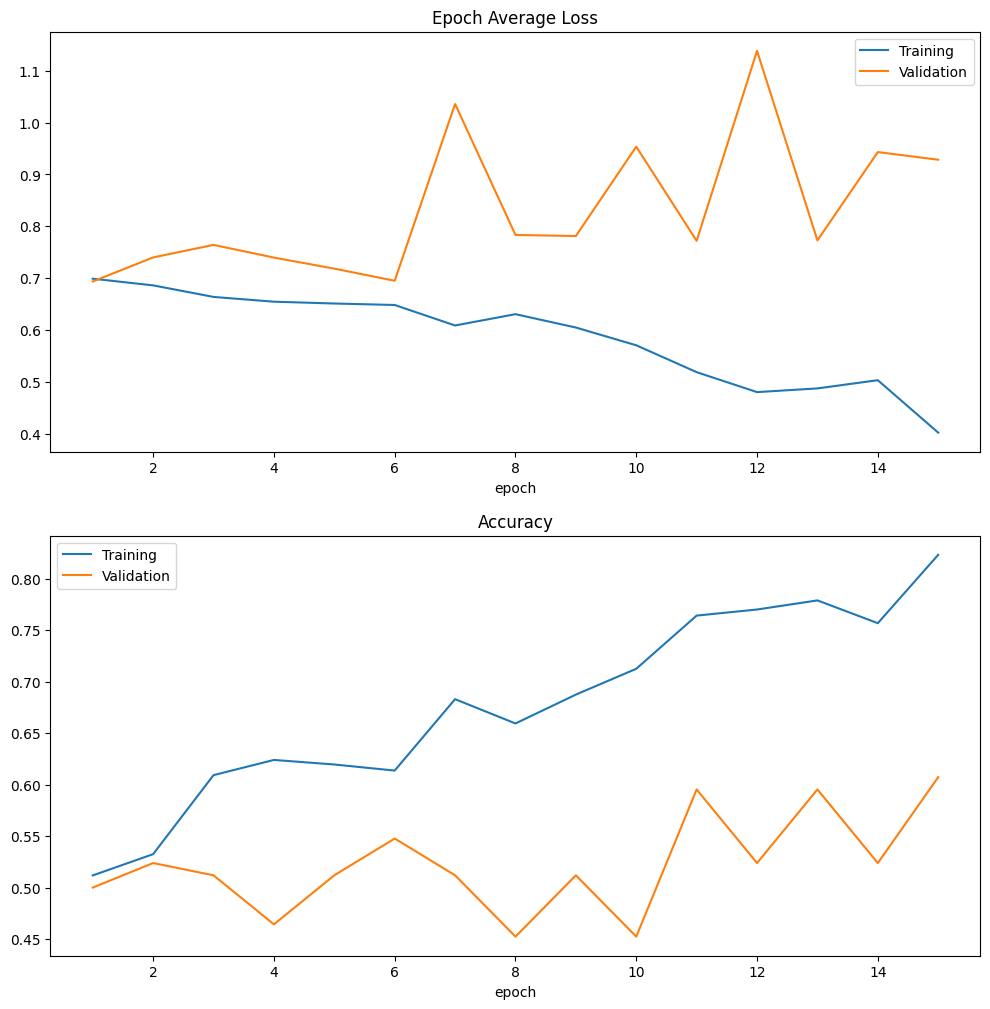

----------
epoch 16/20


Epoch : 100%|██████| 43/43 [00:26<00:00,  1.60it/s, Overall Training Loss=0.856]


current epoch: 16 current avg accuracy: 0.5000 best accuracy: 0.6071 at epoch 15
Num guessed positive: 
343
train accuracy: 0.8333 validation accuracy: 0.5000 train loss: 0.3821 validation loss 1.3712
----------
epoch 17/20


Epoch : 100%|██████| 43/43 [00:27<00:00,  1.58it/s, Overall Training Loss=0.268]


current epoch: 17 current avg accuracy: 0.5119 best accuracy: 0.6071 at epoch 15
Num guessed positive: 
350
train accuracy: 0.8407 validation accuracy: 0.5119 train loss: 0.3673 validation loss 0.9336
----------
epoch 18/20


Epoch : 100%|██████| 43/43 [00:26<00:00,  1.60it/s, Overall Training Loss=0.319]


current epoch: 18 current avg accuracy: 0.5595 best accuracy: 0.6071 at epoch 15
Num guessed positive: 
361
train accuracy: 0.8805 validation accuracy: 0.5595 train loss: 0.3251 validation loss 1.1931
----------
epoch 19/20


Epoch : 100%|██████████| 43/43 [00:27<00:00,  1.58it/s, Overall Training Loss=1]


current epoch: 19 current avg accuracy: 0.5238 best accuracy: 0.6071 at epoch 15
Num guessed positive: 
357
train accuracy: 0.8481 validation accuracy: 0.5238 train loss: 0.3553 validation loss 1.3021
----------
epoch 20/20


Epoch : 100%|██████| 43/43 [00:27<00:00,  1.57it/s, Overall Training Loss=0.275]


current epoch: 20 current avg accuracy: 0.5476 best accuracy: 0.6071 at epoch 15
Num guessed positive: 
351
train accuracy: 0.8392 validation accuracy: 0.5476 train loss: 0.3559 validation loss 0.9251


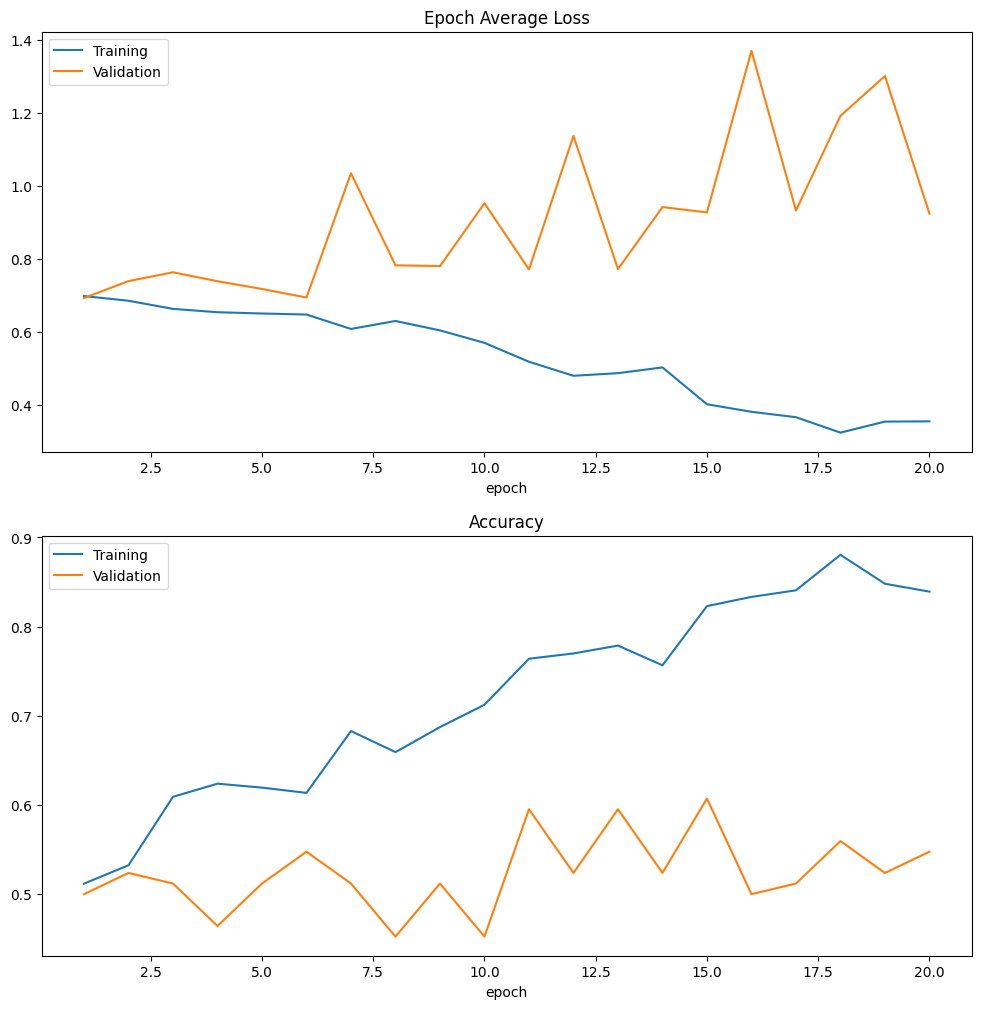

train completed, best_metric: 0.6071 at epoch: 15


In [11]:
val_interval = 1    # validate at every n epochs
graph_interval = 5    # plot training graphs every n epochs

best_metric = -1    # default value
best_metric_epoch = -1    # default value

# arrays to keep track of loss and accuracy for plotting curves
train_loss = []
val_loss = []
train_acc = []
val_acc = []


train_acc = []
val_acc = []

num_epochs = 20

torch.cuda.empty_cache()

for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    num_correct = 0.0
    metric_count = 0
    num_guessed_positive = 0
    
    # TRAINING
    # using tqdm will show progress bar for each epoch
    with tqdm(train_loader, desc=("Epoch ")) as pbar:
        # iterate through train_loader batches
        for i, batch_data in enumerate(pbar):
            step += 1
            image = torch.cat((batch_data["t1"].to(device, dtype=torch.float), batch_data["t1c"].to(device, dtype=torch.float), batch_data["t2"].to(device, dtype=torch.float), batch_data["flair"].to(device, dtype=torch.float)), dim = 1) 
            labels = torch.zeros(len(batch_data["t1"]), 2).to(device)
            
            for i in range(len(batch_data["t1"])):
                labels[i] = torch.from_numpy(np.asarray([batch_data["MGMTn"][i], batch_data["MGMTp"][i]]).astype('int64'))
            
            optimizer.zero_grad()
            output = model(image)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()
            
            # values for calculating accuracy
            num_guessed_positive += (torch.sigmoid(output[:, 1]) > torch.sigmoid(output[:, 0])).sum().item()
            value = torch.eq((torch.sigmoid(output[:, 1]) > torch.sigmoid(output[:, 0])).float(), labels[:, 1])
            metric_count += len(value)
            num_correct += value.sum().item()    
            
            # epoch loss
            epoch_loss += loss.item()
                                                                                      
            epoch_len = len(train_ds) // train_loader.batch_size
            
            # update progress bar to display loss
            pbar.set_postfix({'Overall Training Loss': loss.item()})
            
        # append loss and accuracy
        epoch_loss /= step
        train_loss.append(epoch_loss)
        metric = num_correct / metric_count
        train_acc.append(metric)
    
        # VALIDATION
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():

                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                                                                
                
                # iterate through valid_loader batches
                for i, val_data in enumerate(valid_loader):
                    val_image = torch.cat((val_data["t1"].to(device, dtype=torch.float), val_data["t1c"].to(device, dtype=torch.float), val_data["t2"].to(device, dtype=torch.float), val_data["flair"].to(device, dtype=torch.float)), dim=1)
                    val_labels = torch.zeros(len(val_data["t1"]), 2).to(device)
            
                    for i in range(len(val_data["t1"])):
                        val_labels[i] = torch.from_numpy(np.asarray([val_data["MGMTn"][i], val_data["MGMTp"][i]]).astype('int64'))
                        
                    output = model(val_image)
                    y_pred = torch.cat([y_pred, output], dim=0)
                    y = torch.cat([y, val_labels], dim=0)
                    
                # calculate and append loss
                loss = loss_function(y_pred, y)
                val_loss.append(loss.item())
                
                # calculate and append accuracy
                acc_value = torch.eq((torch.sigmoid(y_pred[:, 1]) > torch.sigmoid(y_pred[:, 0])).float(), y[:, 1])
                acc_metric = (acc_value.sum().item()) / len(acc_value)
                val_acc.append(acc_metric)


                # update best metric
                if acc_metric > best_metric:
                    best_metric = acc_metric
                    best_metric_epoch = epoch + 1
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                        'train_loss_arr': train_loss,
                        'val_loss_arr': val_loss,
                        'train_acc_arr': train_acc,
                        'val_acc_arr': val_acc,
                        'val_acc': val_acc,
                        'train_acc': train_acc,
                        }, "best_metric_densenet.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current avg accuracy: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                        epoch + 1, acc_metric, best_metric, best_metric_epoch
                    )
                )
                print("Num guessed positive: ")
                print(num_guessed_positive)
                print(
                    "train accuracy: {:.4f} validation accuracy: {:.4f} train loss: {:.4f} validation loss {:.4f}".format(
                        train_acc[-1], acc_metric, train_loss[-1],loss.item()
                    )
                )
                
        # display train/validation curves
        if (epoch + 1) % graph_interval == 0:
            plot_curves(train_loss, val_loss, train_acc, val_acc)
        
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

## 4. Evaluating Results

### 4.1 Evaluating the Model on the Test Dataset

In [14]:
torch.cuda.empty_cache()

saved_dict = torch.load("best_metric_densenet.pth")
model.load_state_dict(saved_dict['model_state_dict'])
model.eval()

y_pred = torch.tensor([]).to(device)
y = torch.tensor([]).to(device)
                                                                
                
# iterate through test_loader batches
for test_data in test_loader:
    with torch.no_grad():
        test_image = torch.cat((test_data["t1"].to(device, dtype=torch.float), test_data["t1c"].to(device, dtype=torch.float), test_data["t2"].to(device, dtype=torch.float), test_data["flair"].to(device, dtype=torch.float)), dim=1)
        test_labels = torch.zeros(len(test_data["t1"]), 2).to(device)
            
        for i in range(len(test_data["t1"])):
            test_labels[i] = torch.from_numpy(np.asarray([test_data["MGMTn"][i], test_data["MGMTp"][i]]).astype('int64'))
                        
        output = torch.sigmoid(model(test_image))
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, test_labels], dim=0)


print(y_pred)
print(y)


tensor([[0.7127, 0.2255],
        [0.3364, 0.6616],
        [0.3466, 0.5989],
        [0.2299, 0.7720],
        [0.4543, 0.4918],
        [0.4925, 0.4898],
        [0.3654, 0.6385],
        [0.5181, 0.4266],
        [0.6878, 0.2219],
        [0.4482, 0.5712],
        [0.1390, 0.8602],
        [0.6244, 0.3719],
        [0.4966, 0.5362],
        [0.3143, 0.6814],
        [0.4841, 0.4597],
        [0.2161, 0.7587],
        [0.5511, 0.3561],
        [0.4316, 0.5274],
        [0.1808, 0.8299],
        [0.5283, 0.4460],
        [0.3843, 0.6132],
        [0.4071, 0.6102],
        [0.3744, 0.6036],
        [0.3972, 0.5548],
        [0.2359, 0.7602],
        [0.2619, 0.7411],
        [0.1479, 0.8608],
        [0.3113, 0.6952],
        [0.6897, 0.2017],
        [0.6629, 0.2439],
        [0.3341, 0.6463],
        [0.5134, 0.4096],
        [0.5081, 0.4593],
        [0.5901, 0.3573],
        [0.5277, 0.4273],
        [0.4698, 0.5119],
        [0.3561, 0.6400],
        [0.5696, 0.4015],
        [0.5

#### 4.1.2 Classification Report

In [17]:
truth = y.cpu()
guess = round(y_pred.cpu())


print(metrics.classification_report(y.cpu(), y_pred.cpu(), target_names=["UNMETHYLATED", "METHYLATED"], digits=4))



TypeError: type Tensor doesn't define __round__ method

#### 4.1.3 Confusion Matrix

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["UNMETHYLATED", "METHYLATED"])
cm_display.plot()
plt.show()

In [1]:
# What the model is learning from training set doesn't seem to be generalizing to test set

%reset -f